# Evolving a Lunar Lander with differentiable Genetic Programming

## Installation
To install the required libraries run the command:

In [11]:
!pip install -r requirements.txt

    extract-msg (<=0.29.*)
                 ~~~~~~~^

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


## Imports
Imports from the standard genepro-multi library are done here. Any adjustments (e.g. different operators) should be made in the notebook. For example:

```
class SmoothOperator(Node):
  def __init__(self):
    super(SmoothOperator,self).__init__()
    self.arity = 1
    self.symb = "SmoothOperator"

  def _get_args_repr(self, args):
    return self._get_typical_repr(args,'before')

  def get_output(self, X):
    c_outs = self._get_child_outputs(X)
    return np.smoothOperation(c_outs[0])

  def get_output_pt(self, X):
    c_outs = self._get_child_outputs_pt(X)
    return torch.smoothOperation(c_outs[0])
```

In [12]:
import gymnasium as gym

from genepro.node_impl import *
from genepro.evo import Evolution
from genepro.node_impl import Constant

import torch
import torch.optim as optim

import random
import os
import copy
from collections import namedtuple, deque

import matplotlib.pyplot as plt
from matplotlib import animation

## Reinforcement Learning Setup
Here we first setup the Gymnasium environment. Please see https://gymnasium.farama.org/environments/box2d/lunar_lander/ for more information on the environment. 

Then a memory buffer is made. This is a buffer in which state transitions are stored. When the buffer reaches its maximum capacity old transitions are replaced by new ones.

A frame buffer is initialised, used to later store animation frames of the environment.

#### Adding Wind

Wind can be added to the current environment setup as below:

```bash
env = gym.make("LunarLander-v3", continuous=False,
               enable_wind=True, wind_power=15.0, turbulence_power=1.5)
```

Selin: When we add wind as a variable, it makes sense to also edit our fitness function. We can define a new boolean parameter (say have_random_wind) and if it is set to true when the fitness function is called, we can re-define the environment with a random wind value at each episode. This would potentially make our GP algorithm more robust to randomness. A possible implementation:

```bash
if use_random_wind:
    env = gym.make("LunarLander-v3", continuous=False,
                    enable_wind=True,
                    wind_power=np.random.uniform(5.0, 20.0),
                    turbulence_power=np.random.uniform(0.5, 2.0))
```

The above can be added within the loop that goes over the episodes (the outer for loop of the fitness function).

#### Adding new Atomic Functions

These atomic functions will be added as internal nodes within the Evolution setup.

We can add min & max operators. Or instead, we can add **Clamp(x, min, max)** operator. This could be interesting.

We can add domain specific operators:
- Maybe a function that calculates the angle of the lunarlander to the pad (angle_to_pad(x_pos, y_pos)?)

#### Fitness Calculation

For the final fitness calculation, we are taking the sum of the rewards across episodes. Instead of sum operation, can we do this fitness calculation in a more clever way?

In [13]:
env = gym.make("LunarLander-v3", render_mode="rgb_array")

In [14]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

    def __iadd__(self, other):
      self.memory += other.memory
      return self 

    def __add__(self, other):
      self.memory = self.memory + other.memory 
      return self

In [15]:
frames = []

## Fitness Function

Here you get to be creative. The default setup evaluates 5 episodes of 300 frames. Think of what action to pick and what fitness function to use. The Multi-tree takes an input of $n \times d$ where $n$ is a batch of size 1.

### Selin's Notes

**Fitness Function:** Fitness is defined as the cumulative reward of the landing.

**Multitree:** Multitree contains 4 trees, one for each action of the Lunar lander. 

- `0`: do nothing
- `1`: fire left orientation engine
- `2`: fire main engine
- `3`: fire right orientation engine

Multitree is initialized under genepro/variation.py file, with the generate_random_multitree() method. This method is called in the genepro/evo.py file within the _initialize_population() internal method. 

**Understanding the Input Sample:** Input sample is an 8-dimensional vector: [x, y, vx, vy, angle, angular_velocity, leg1_contact, leg2_contact]

e.g. [-2.5, -2.5, -10, -10, -6.28, -10, 0, 0]

- index0 : x position of the lander
- index1: y position of the lander
- index2: velocity in the x direction
- index3: velocity in the y direction
- index4: angle of the lander
- index5: angular velocity
- index6: leg 1 in contact
- index7: leg 2 in contact
      


In [16]:
def fitness_function_pt(multitree, num_episodes=5, episode_duration=300, render=False, ignore_done=False):
  memory = ReplayMemory(10000)
  rewards = []

  for _ in range(num_episodes):
    # get initial state of the environment
    observation = env.reset()
    observation = observation[0]
    
    for _ in range(episode_duration):
      if render:
        frames.append(env.render())

      input_sample = torch.from_numpy(observation.reshape((1,-1))).float() # Input sample is a torch tensor

      # what goes here? TODO
      '''Below is Selin's possible definition of an action'''
      output_scores = multitree.get_output_pt(input_sample) # A tensor of length 4, storing the scores of each action (after evaluating each tree)
      action = torch.argmax(output_scores, dim=1) # Select the action with the highest score

      observation, reward, terminated, truncated, info = env.step(action.item())
      rewards.append(reward)
      output_sample = torch.from_numpy(observation.reshape((1,-1))).float()
      memory.push(input_sample, torch.tensor([[action.item()]]), output_sample, torch.tensor([reward]))
      if (terminated or truncated) and not ignore_done:
        break

  fitness = np.sum(rewards)
  
  return fitness, memory

## Evolution Setup
Here the leaf and internal nodes are defined. Think about the odds of sampling a constant in this default configurations. Also think about any operators that could be useful and add them here. 

Adjust the population size (multiple of 8 if you want to use the standard tournament selection), max generations and max tree size to taste. Be aware that each of these settings can increase the runtime.

#### Selin's ideas about the things they wanted us to consider in the evolution setup (possible areas for improvement)

In the below code, it says **Think about the probability of sampling a coefficient (which is basically a constant).** Currently, in the below code, we have 8 features and we are adding all of them as leaf nodes. 

However, we are only adding 1 constant as a leaf node. So this would give us a 1/9 chance of sampling a coefficient. This is a very small probability. Hence, **a possible area of improvement** might be to consider adding more constants (e.g. 4 or 5 constants) to our leaf nodes set and see how our GP performs. I think having constant is **important** because they allow the model to shift or scale features (e.g. x_4 + 1.5).

**Having more operators:** Currently, we only have basic arithmetic operators. We can add the following non-linear operators:
- log
- sqrt
- sin, cos
- max, min
- exp
- square, cube, ...

**Adjusting the parameters of the Evolution() method** called below. We can design an experiment to find the best combination of parameter values for population size, max generations, and max tree size.

In [17]:
num_features = env.observation_space.shape[0]
leaf_nodes = [Feature(i) for i in range(num_features)]
leaf_nodes = leaf_nodes + [Constant()] # Think about the probability of sampling a coefficient
internal_nodes = [Plus(),Minus(),Times(),Div()] # Add your own operators here

evo = Evolution(
  fitness_function_pt, internal_nodes, leaf_nodes,
  4,
  pop_size=16,
  max_gens=10,
  max_tree_size=31,
  n_jobs=8,
  verbose=True)

## Evolve
Running this cell will use all the settings above as parameters

In [18]:
best_fitnesses_across_gens = evo.evolve()

gen: 1,	best of gen fitness: -533.884,	best of gen size: 31
gen: 2,	best of gen fitness: -423.002,	best of gen size: 31
gen: 3,	best of gen fitness: -457.568,	best of gen size: 31
gen: 4,	best of gen fitness: -529.753,	best of gen size: 31
gen: 5,	best of gen fitness: -418.372,	best of gen size: 31
gen: 6,	best of gen fitness: -547.321,	best of gen size: 31
gen: 7,	best of gen fitness: -571.784,	best of gen size: 25
gen: 8,	best of gen fitness: -474.766,	best of gen size: 25
gen: 9,	best of gen fitness: -525.457,	best of gen size: 29
gen: 10,	best of gen fitness: -555.341,	best of gen size: 25


In [19]:
print(best_fitnesses_across_gens)

[-533.8839712276588, -423.0018100732037, -457.56793549399487, -529.7531431012277, -418.37220535455555, -547.3213914915754, -571.7838070245036, -474.7662019427874, -525.4574701282942, -555.3411738870714]


# Test

In [20]:
def get_test_score(tree):
    rewards = []

    for i in range(10):
      # get initial state
      observation = env.reset(seed=i)
      observation = observation[0]

      for _ in range(500):    
        # build up the input sample for GP
        input_sample = torch.from_numpy(observation.reshape((1,-1))).float()
        
        # TODO: Again, define the action
        '''Selin's idea of an action is added below'''
        # get output (squeezing because it is encapsulated in an array)
        output = tree.get_output_pt(input_sample)
        action = torch.argmax(output, dim=1) # Select the action with the highest score
        
        observation, reward, terminated, truncated, info = env.step(action.item())
        rewards.append(reward)
        output_sample = torch.from_numpy(observation.reshape((1,-1))).float()
        if (terminated or truncated):
            break

    fitness = np.sum(rewards)
    
    return fitness

best = evo.best_of_gens[-1]

print(best.get_readable_repr())
print(get_test_score(best))

['(((x_5/x_6)+(-3.7748808065959762*(x_1*x_3)))*(((x_6-x_1)+(-3.0595815181732178*x_6))/(x_6-x_4)))', '(x_3/(((4.227174104968074/x_6)+x_3)+((x_3/x_4)*((x_3/x_4)*(-3.1707377433776855-x_7)))))', '(x_1/1.594401240348816)', '(((x_1-x_2)*((-3.8168256282806396+x_5)/x_0))/(-2.6871719360351562*((x_1-3.2856736183166504)+(-2.6871719360351562*((x_1-3.2856736183166504)+(x_6*0.9377084374427795))))))']
-1388.155481696797


## Our Experimentation Setup

In [21]:
# TEST TYPE 1. Improving the Fitness Function
'''
Configuring the fitness function
TEST 1.1 Single objective: Experiment with different quality metrics for fitness
TEST 1.2 Multi-objective: Include diversity as a second metric

Required additional arguments for fitness function: has_wind=False, reward_type='sum', is_multiobjective=False
where reward_types = ['sum', 'min', 'weighted_sum']

Wind Test 
Adding wind as a variable, and also adding a random wind value at each episode
''' 

"\nConfiguring the fitness function\nTEST 1.1 Single objective: Experiment with different quality metrics for fitness\nTEST 1.2 Multi-objective: Include diversity as a second metric\n\nRequired additional arguments for fitness function: has_wind=False, reward_type='sum', is_multiobjective=False\nwhere reward_types = ['sum', 'min', 'weighted_sum']\n\nWind Test \nAdding wind as a variable, and also adding a random wind value at each episode\n"

In [22]:
def main_experimentation_loop(fitness_function_version, internal_nodes, leaf_nodes,
                                pop_size=16, max_gens=10, max_tree_size=31):
            
    # Initialize an evolution setup with the correct fitness function
    evo = Evolution(
            fitness_function_version, 
            internal_nodes, 
            leaf_nodes,
            n_trees=4, # Number of trees in multitree is fixed to 4
            pop_size=pop_size,
            max_gens=max_gens,
            max_tree_size=max_tree_size,
            n_jobs=8, # Number of jobs is fixed to 8
            verbose=True)
    
    # Run the training loop for this evolution setup and get the fitnesses of the best individuals across generations
    best_fitnesses_training = evo.evolve()

    # Now, run the testing loop for this evolution setup and get the fitnesses of the best individuals across generations
    # Extract best-of-generation trees
    best_individuals = evo.best_of_gens

    # Collect test scores for each best individual
    best_fitnesses_test = [
        get_test_score(ind) for ind in best_individuals
    ]

    return best_fitnesses_training, best_fitnesses_test

## Make an animation
Here the best evolved individual is selected and one episode is rendered. Make sure to save your lunar landers over time to track progress and make comparisons.

MovieWriter imagemagick unavailable; using Pillow instead.


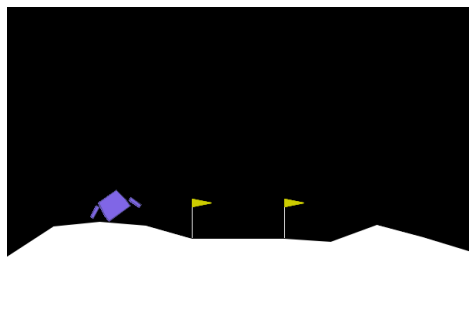

In [23]:
frames = []

# gist to save gif from https://gist.github.com/botforge/64cbb71780e6208172bbf03cd9293553
def save_frames_as_gif(frames, path='./', filename='evolved_lander.gif'):
  plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
  patch = plt.imshow(frames[0])
  plt.axis('off')
  def animate(i):
      patch.set_data(frames[i])
  anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
  anim.save(path + filename, writer='imagemagick', fps=60)

frames = []
fitness_function_pt(best, num_episodes=1, episode_duration=500, render=True, ignore_done=False)
env.close()
save_frames_as_gif(frames)

## Play animation

<img src="evolved_lander.gif" width="750">

## Optimisation
The coefficients in the multi-tree aren't optimised. Here Q-learning (taken from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) is used to optimise the weights further. Incorporate coefficient optimisation in training your agent(s). Coefficient Optimisation can be expensive. Think about how often you want to optimise, when, which individuals etc.

In [24]:
batch_size = 128
GAMMA = 0.99

constants = best.get_subtrees_consts()

if len(constants)>0:
  optimizer = optim.AdamW(constants, lr=1e-3, amsgrad=True)

for _ in range(500):

  if len(constants)>0 and len(evo.memory)>batch_size:
    target_tree = copy.deepcopy(best)

    transitions = evo.memory.sample(batch_size)
    batch = Transition(*zip(*transitions))
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                        batch.next_state)), dtype=torch.bool)

    non_final_next_states = torch.cat([s for s in batch.next_state
                                               if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = best.get_output_pt(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(batch_size, dtype=torch.float)
    with torch.no_grad():
      next_state_values[non_final_mask] = target_tree.get_output_pt(non_final_next_states).max(1)[0].float()

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
   
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(constants, 100)
    optimizer.step()

print(best.get_readable_repr())
print(get_test_score(best))

['(((x_5/x_6)+(-4.11182176485342*(x_1*x_3)))*(((x_6-x_1)+(-2.984497547149658*x_6))/(x_6-x_4)))', '(x_3/(((4.09736595655765/x_6)+x_3)+((x_3/x_4)*((x_3/x_4)*(-3.2708077430725098-x_7)))))', '(x_1/1.0128785371780396)', '(((x_1-x_2)*((-3.708533525466919+x_5)/x_0))/(-2.770970106124878*((x_1-3.142789125442505)+(-2.66524600982666*((x_1-3.4329545497894287)+(x_6*0.9270513653755188))))))']
-1388.155481696797


MovieWriter imagemagick unavailable; using Pillow instead.


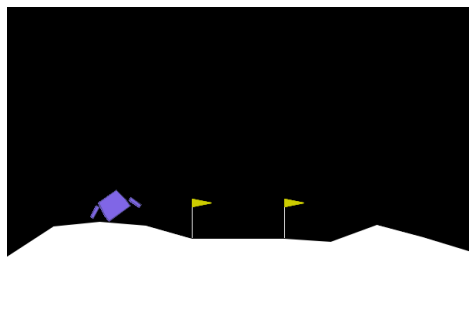

In [25]:
frames = []
fitness_function_pt(best, num_episodes=1, episode_duration=500, render=True, ignore_done=False)
env.close()
save_frames_as_gif(frames, filename='evolved_lander_RL.gif')

<img src="evolved_lander_RL.gif" width="750">